In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
import warnings

In [2]:
data = pd.read_csv('apartments.csv')
column_names = data.columns
data.head()

,Price,Bedrooms,Bathrooms,Size
0,ZMW2400000,3.0,2.5,80m²
1,ZMW3250000,3.0,1.0,150m²
2,ZMW5500000,2.0,NaN,1600m²
3,ZMW550000,1.0,1.0,57m²
4,ZMW22100000,NaN,NaN,4000m²


In [3]:
data['Price'] = data['Price'].str.extract('(\d+)').astype(float)
data['Price'] = data['Price'] * 0.03514186

data = data[(data['Price'] >= 5000) & (data['Price'] <= 1000000)]

In [4]:
def size_cleared(value):
    if isinstance(value, (float, int)):
        return float(value)
    elif 'm²' in value:
        return float(value.replace('m²', '').strip())
    elif 'acres' in value:
        acres = float(value.replace('acres', '').strip())
        return acres * 4046.86
    else:
        return np.nan

data['Size'] = data['Size'].apply(size_cleared)
data = data[(data['Size'].isna()) | ((data['Size'] >= 15) & (data['Size'] <= 0.5e+07))]

In [5]:
data = data[(data['Bathrooms'] <= 6) & (data['Bedrooms'] <= 5)]

In [6]:
data.describe()

,Price,Bedrooms,Bathrooms,Size
count,138.000000,138.000000,138.000000,57.000000
mean,120184.273231,2.543478,1.952899,891.120351
std,137602.919136,0.651999,0.688508,843.530236
min,15813.837000,1.000000,1.000000,57.000000
25%,49198.604000,2.000000,2.000000,460.000000
50%,73797.906000,3.000000,2.000000,600.000000
75%,131342.701750,3.000000,2.000000,1200.000000
max,773120.920000,4.000000,4.000000,4046.860000


In [7]:
mode_bedrooms = data['Bedrooms'].mode()[0]
data['Bedrooms'] = data['Bedrooms'].fillna(mode_bedrooms)

mode_bathrooms = data['Bathrooms'].mode()[0]
data['Bathrooms'] = data['Bathrooms'].fillna(mode_bathrooms)

# VIZUALIZACIJA

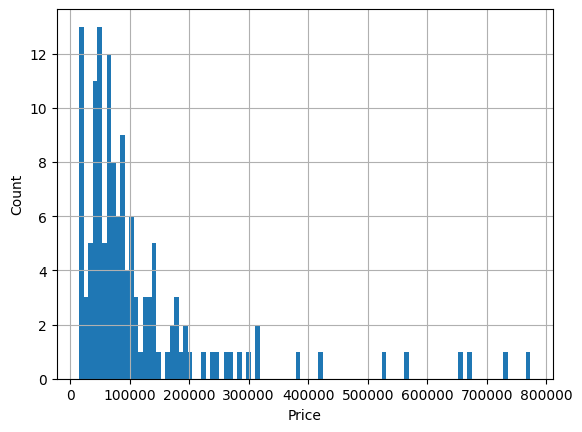

In [8]:
data["Price"].hist(bins=100)
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

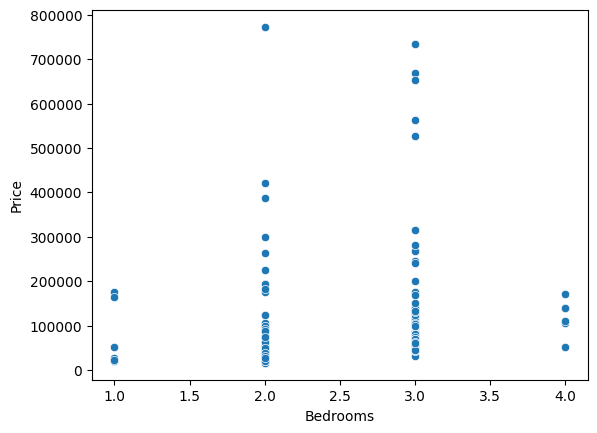

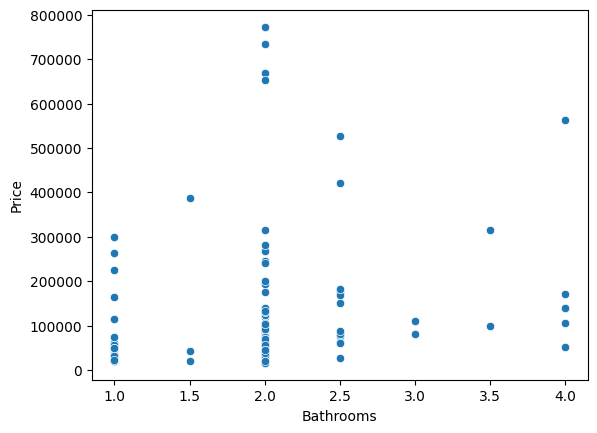

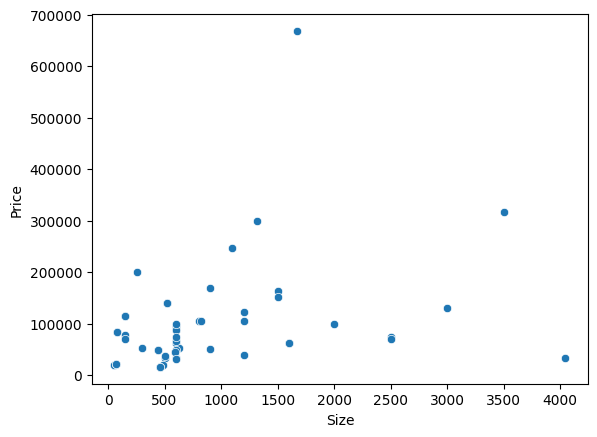

In [9]:
for i, col in enumerate(['Bedrooms', 'Bathrooms', 'Size']):
    plt.figure(i)
    sns.scatterplot(data, x=str(col), y='Price')

### PODATKE S PODATKOM O VELIKOSTI UPORABIM KOT UČNE, PREOSTALIM BOM IZRAČUNALA VELIKOST

In [16]:
X_train = data.dropna(subset=['Size']).drop('Size', axis=1).to_numpy()

y_train = data.dropna(subset=['Size'])['Size'].to_numpy()
y_train = y_train[:, None]

X_pred = data[data['Size'].isna()].drop('Size', axis=1).to_numpy()

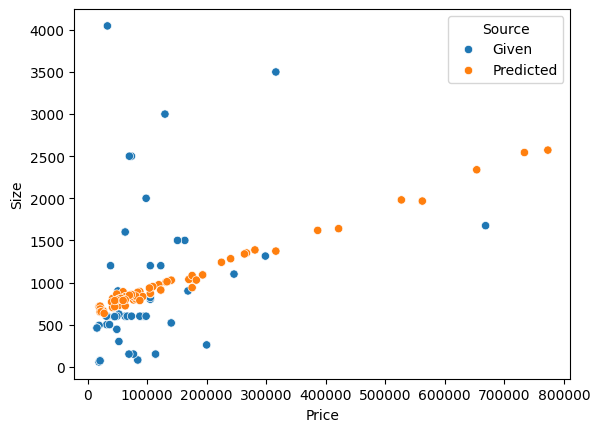

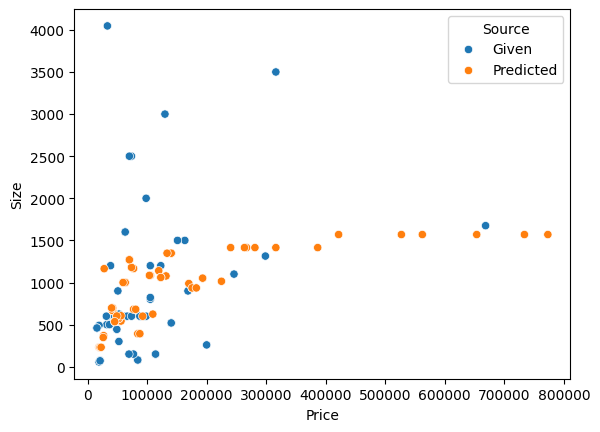

In [17]:
lm = LinearRegression().fit(X_train, y_train)
y_pred_lr = lm.predict(X_pred)

knn = KNeighborsRegressor().fit(X_train, y_train)
y_pred_knn = knn.predict(X_pred)

X_pred = pd.DataFrame(X_pred, columns=column_names[:-1])

y_pred_lr = pd.DataFrame(y_pred_lr, columns=column_names[-1:])
data_size_lr = pd.concat([X_pred, y_pred_lr], axis=1)

y_pred_knn = pd.DataFrame(y_pred_knn, columns=column_names[-1:])
data_size_knn = pd.concat([X_pred, y_pred_knn], axis=1)

data_size_lr['Source'] = 'Predicted'
data_size_knn['Source'] = 'Predicted'

data_size_given = data.dropna(subset=['Size']).copy()
data_size_given.loc[:, 'Source'] = 'Given'

data_lr = pd.concat([data_size_given, data_size_lr])
data_knn = pd.concat([data_size_given, data_size_knn])

for i, tab in enumerate([data_lr, data_knn]):
    plt.figure(i)
    sns.scatterplot(tab, x='Price', y='Size', hue='Source')